# Secure AI MNIST: Assignment Notebook

Run this notebook to train the baseline CNN, generate adversarial and poisoned data, defend with adversarial training, and summarize metrics/plots for presentation.

## Setup and Imports
Configures paths, seeds, and libraries.

In [10]:
import os, json, time, math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models # type: ignore
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier

pd.set_option('display.max_colwidth', None)
np.random.seed(42)
tf.random.set_seed(42)

# Resolve project root (handles running from notebooks/ or repo root)
CWD = Path.cwd().resolve()
if (CWD / 'code').exists():
    BASE_DIR = CWD
elif (CWD.name == 'notebooks') and (CWD.parent / 'code').exists():
    BASE_DIR = CWD.parent
else:
    BASE_DIR = CWD

FIG_DIR = BASE_DIR / 'figures'
MODEL_DIR = BASE_DIR / 'models'
REPORT_DIR = BASE_DIR / 'reports'
FIG_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
REPORT_DIR.mkdir(parents=True, exist_ok=True)

print('Base dir:', BASE_DIR)


Base dir: /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist


## Toggles and Hyperparameters
Switch `USE_EXISTING_MODELS` to `False` to force retraining.

In [11]:
USE_EXISTING_MODELS = False  # set False to retrain models from scratch
BASELINE_EPOCHS = 8
ADV_TRAIN_EPOCHS = 5
POISON_EPOCHS = 5
BATCH_SIZE = 128
FGSM_EPS = 0.25
PATCH_SIZE = 4
PATCH_VALUE = 255
TARGET_CLASS = 7

print('Config loaded')


Config loaded


## Helper Functions

In [12]:
def load_data():
    local_path = Path.home() / '.keras' / 'datasets' / 'mnist.npz'
    if local_path.exists():
        with np.load(local_path) as data:
            x_train, y_train = data['x_train'], data['y_train']
            x_test, y_test = data['x_test'], data['y_test']
    else:
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train.astype('float32') / 255.0)[..., None]
    x_test = (x_test.astype('float32') / 255.0)[..., None]
    return x_train, y_train, x_test, y_test


## Load Data

In [13]:
x_train, y_train, x_test, y_test = load_data()
print('Train:', x_train.shape, 'Test:', x_test.shape)


Train: (60000, 28, 28, 1) Test: (10000, 28, 28, 1)


## Baseline Training + Evaluation
Loads existing model if present (unless toggled), otherwise trains and saves artifacts/metrics.

Epoch 1/8
422/422 - 11s - 27ms/step - accuracy: 0.9058 - loss: 0.3041 - val_accuracy: 0.9808 - val_loss: 0.0756
Epoch 2/8
422/422 - 10s - 23ms/step - accuracy: 0.9638 - loss: 0.1389 - val_accuracy: 0.9848 - val_loss: 0.0752
Epoch 3/8
422/422 - 10s - 23ms/step - accuracy: 0.9672 - loss: 0.1483 - val_accuracy: 0.9823 - val_loss: 0.1046
Epoch 4/8
422/422 - 10s - 23ms/step - accuracy: 0.9683 - loss: 0.1868 - val_accuracy: 0.9808 - val_loss: 0.1317
Epoch 5/8
422/422 - 10s - 24ms/step - accuracy: 0.9694 - loss: 0.2317 - val_accuracy: 0.9883 - val_loss: 0.1146
Epoch 6/8
422/422 - 10s - 23ms/step - accuracy: 0.9700 - loss: 0.2945 - val_accuracy: 0.9842 - val_loss: 0.1856
Epoch 7/8
422/422 - 10s - 23ms/step - accuracy: 0.9698 - loss: 0.3719 - val_accuracy: 0.9863 - val_loss: 0.2273
Epoch 8/8
422/422 - 10s - 24ms/step - accuracy: 0.9695 - loss: 0.5001 - val_accuracy: 0.9843 - val_loss: 0.3576
Trained baseline and saved to /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/models/baseline_

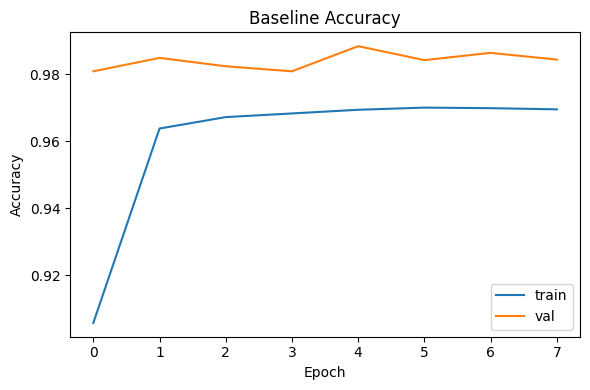

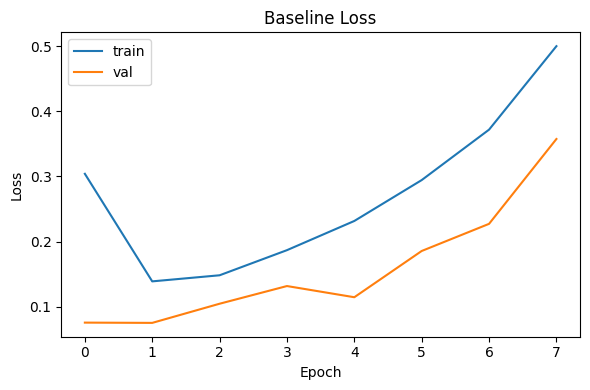

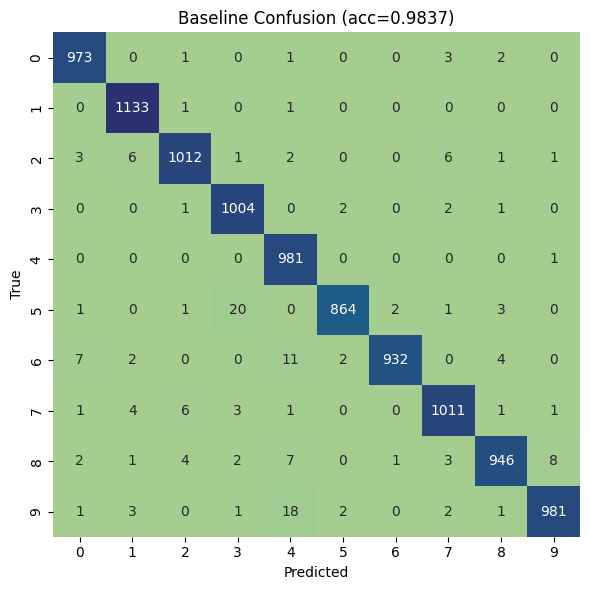

In [14]:
keras_path = MODEL_DIR / 'baseline_cnn.keras'
h5_path = MODEL_DIR / 'baseline_cnn.h5'
model = None
history = None

if USE_EXISTING_MODELS and keras_path.exists():
    model = tf.keras.models.load_model(keras_path)
    print('Loaded existing baseline model (.keras)')
elif USE_EXISTING_MODELS and h5_path.exists():
    model = tf.keras.models.load_model(h5_path)
    print('Loaded existing baseline model (.h5)')
else:
    model = build_cnn()
    t0 = time.time()
    history = model.fit(x_train, y_train, epochs=BASELINE_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=2)
    train_time = time.time() - t0
    model.save(keras_path)
    print(f"Trained baseline and saved to {keras_path}, time={train_time:.2f}s")

# Evaluate
loss, acc, report, cm = evaluate_model(model, x_test, y_test)
inference_time = measure_inference_time(model, x_test)

baseline_metrics = {
    'loss': loss,
    'accuracy': acc,
    'train_time_seconds': float(train_time) if 'train_time' in locals() else None,
    'inference_time_per_image_seconds': inference_time,
    'classification_report': report,
    'epochs': BASELINE_EPOCHS,
    'batch_size': BATCH_SIZE,
    'model_artifacts': {
        'keras': str(keras_path),
        'h5': str(h5_path)
    }
}

save_json(BASE_DIR / 'baseline_metrics.json', baseline_metrics)
plot_history(history, FIG_DIR / 'baseline_acc.png', FIG_DIR / 'baseline_loss.png')
plot_confusion(cm, f'Baseline Confusion (acc={acc:.4f})', FIG_DIR / 'baseline_confusion_matrix.png')


## FGSM Attack (Red Team)

Saved /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/fgsm_metrics.json


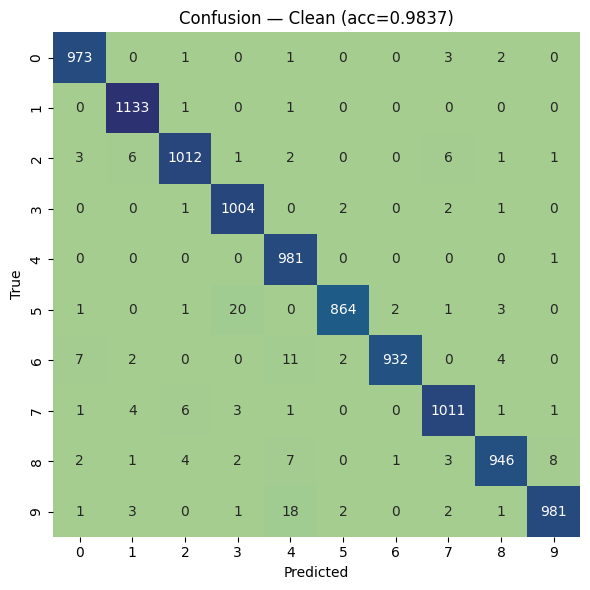

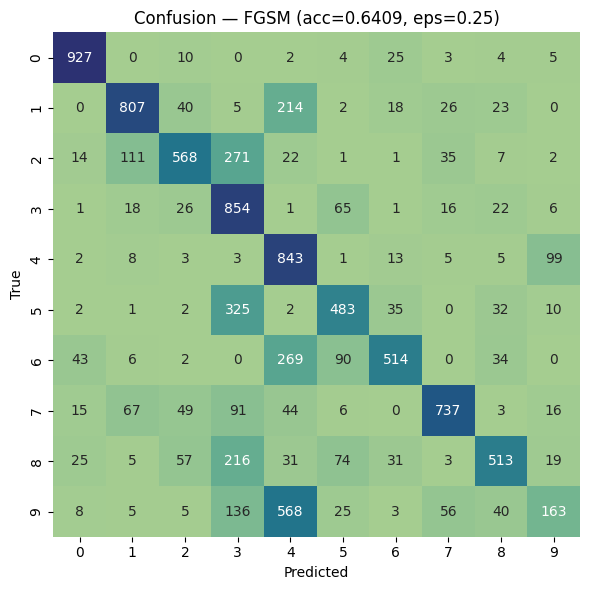

In [15]:
classifier = KerasClassifier(model=model, clip_values=(0.0, 1.0), use_logits=False)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=FGSM_EPS)

start = time.time()
x_test_adv = attack_fgsm.generate(x=x_test)
fgsm_time = time.time() - start

loss_clean, acc_clean_eval = model.evaluate(x_test, y_test, verbose=0)
loss_adv, _ = model.evaluate(x_test_adv, y_test, verbose=0)
y_pred_clean = np.argmax(model.predict(x_test, verbose=0), axis=1)
y_pred_adv = np.argmax(model.predict(x_test_adv, verbose=0), axis=1)
clean_acc = float(np.mean(y_pred_clean == y_test))
adv_acc = float(np.mean(y_pred_adv == y_test))
cm_clean = confusion_matrix(y_test, y_pred_clean)
cm_adv = confusion_matrix(y_test, y_pred_adv)

fgsm_metrics = {
    'attack': 'FGSM',
    'eps': FGSM_EPS,
    'generation_time_sec': fgsm_time,
    'baseline_clean_loss': float(loss_clean),
    'baseline_clean_accuracy': clean_acc,
    'baseline_adversarial_loss': float(loss_adv),
    'baseline_adversarial_accuracy': adv_acc
}
save_json(BASE_DIR / 'fgsm_metrics.json', fgsm_metrics)
plot_confusion(cm_clean, f'Confusion — Clean (acc={clean_acc:.4f})', FIG_DIR / 'fgsm_cm_clean_baseline.png')
plot_confusion(cm_adv, f'Confusion — FGSM (acc={adv_acc:.4f}, eps={FGSM_EPS})', FIG_DIR / 'fgsm_cm_adv_baseline.png')


## Adversarial Training (Blue Team)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Saved /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/advtrain_metrics.json


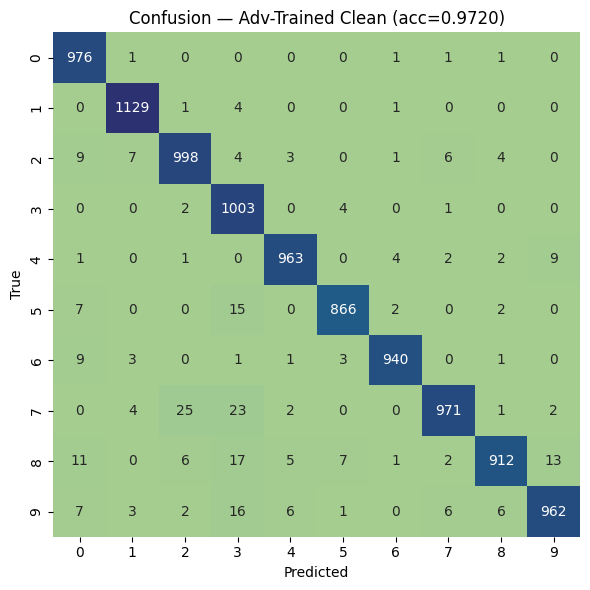

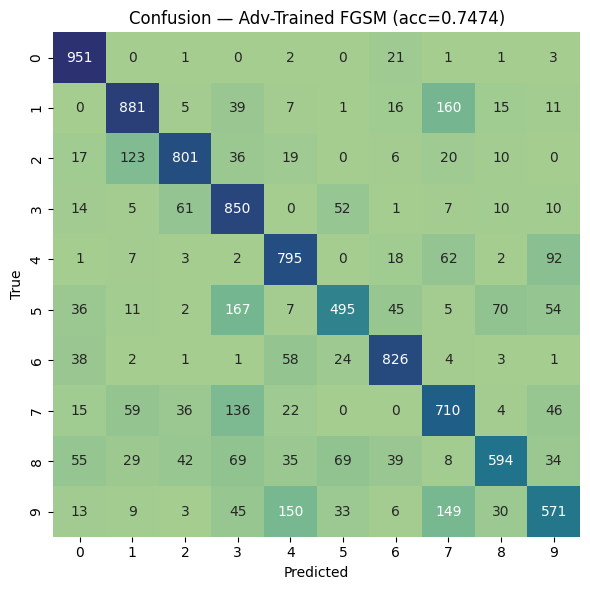

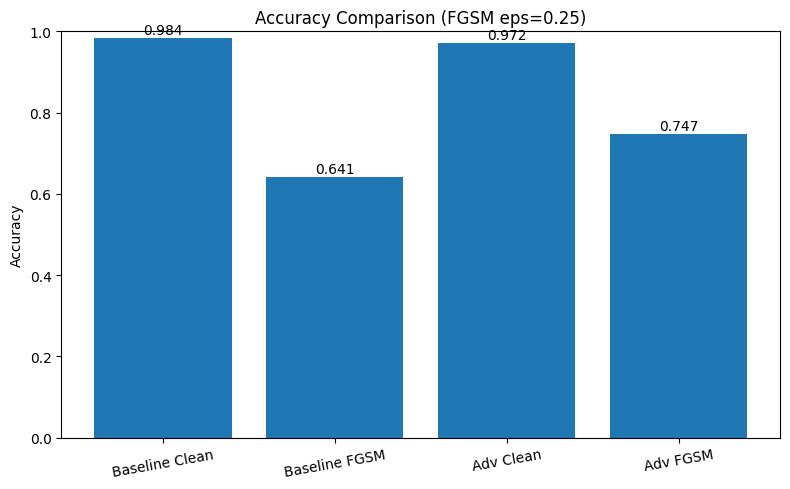

In [16]:
# Reload a fresh copy of the baseline for adversarial training
adv_model = tf.keras.models.load_model(keras_path if keras_path.exists() else h5_path)
adv_classifier = KerasClassifier(model=adv_model, clip_values=(0.0, 1.0), use_logits=False)
trainer = AdversarialTrainer(classifier=adv_classifier, attacks=attack_fgsm, ratio=0.5)

start = time.time()
trainer.fit(x_train, y_train, nb_epochs=ADV_TRAIN_EPOCHS, batch_size=BATCH_SIZE)
adv_train_time = time.time() - start

adv_model_path = MODEL_DIR / 'adv_trained_cnn.keras'
adv_model.save(adv_model_path)

loss_clean_adv, acc_clean_adv = adv_model.evaluate(x_test, y_test, verbose=0)
adv_classifier_for_test = KerasClassifier(model=adv_model, clip_values=(0.0, 1.0), use_logits=False)
attack_fgsm_test = FastGradientMethod(estimator=adv_classifier_for_test, eps=FGSM_EPS)
x_test_adv2 = attack_fgsm_test.generate(x=x_test)
y_pred_adv2 = np.argmax(adv_model.predict(x_test_adv2, verbose=0), axis=1)
loss_adv2, acc_adv2 = adv_model.evaluate(x_test_adv2, y_test, verbose=0)
acc_adv2 = float(acc_adv2)
loss_adv2 = float(loss_adv2)

cm_clean_adv = confusion_matrix(y_test, np.argmax(adv_model.predict(x_test, verbose=0), axis=1))
cm_adv_adv = confusion_matrix(y_test, y_pred_adv2)

adv_metrics = {
    'attack': 'FGSM',
    'eps': FGSM_EPS,
    'advtrain_epochs': ADV_TRAIN_EPOCHS,
    'advtrain_batch_size': BATCH_SIZE,
    'advtrain_time_sec': adv_train_time,
    'advtrained_clean_loss': float(loss_clean_adv),
    'advtrained_clean_accuracy': float(acc_clean_adv),
    'advtrained_adversarial_loss': float(loss_adv2),
    'advtrained_adversarial_accuracy': float(acc_adv2),
    'saved_model': str(adv_model_path)
}
save_json(BASE_DIR / 'advtrain_metrics.json', adv_metrics)
plot_confusion(cm_clean_adv, f'Confusion — Adv-Trained Clean (acc={acc_clean_adv:.4f})', FIG_DIR / 'fgsm_cm_clean_advtrained.png')
plot_confusion(cm_adv_adv, f'Confusion — Adv-Trained FGSM (acc={acc_adv2:.4f})', FIG_DIR / 'fgsm_cm_adv_advtrained.png')

labels = ['Baseline Clean', 'Baseline FGSM', 'Adv Clean', 'Adv FGSM']
values = [clean_acc, adv_acc, float(acc_clean_adv), float(acc_adv2)]
fig = plt.figure(figsize=(8,5))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=10)
plt.ylim(0,1.0)
plt.ylabel('Accuracy')
plt.title(f'Accuracy Comparison (FGSM eps={FGSM_EPS})')
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.tight_layout()
fig.savefig(FIG_DIR / 'fgsm_accuracy_comparison.png', bbox_inches='tight')
plt.show(); plt.close(fig)


## Data Poisoning (Patch Trigger)

Epoch 1/5
422/422 - 11s - 25ms/step - accuracy: 0.8946 - loss: 0.3502 - val_accuracy: 0.9770 - val_loss: 0.0866
Epoch 2/5
422/422 - 9s - 22ms/step - accuracy: 0.9567 - loss: 0.1799 - val_accuracy: 0.9837 - val_loss: 0.0750
Epoch 3/5
422/422 - 9s - 21ms/step - accuracy: 0.9629 - loss: 0.1869 - val_accuracy: 0.9830 - val_loss: 0.1048
Epoch 4/5
422/422 - 9s - 21ms/step - accuracy: 0.9643 - loss: 0.2355 - val_accuracy: 0.9860 - val_loss: 0.1162
Epoch 5/5
422/422 - 9s - 22ms/step - accuracy: 0.9651 - loss: 0.3152 - val_accuracy: 0.9847 - val_loss: 0.1748
Saved /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/poison_metrics.json


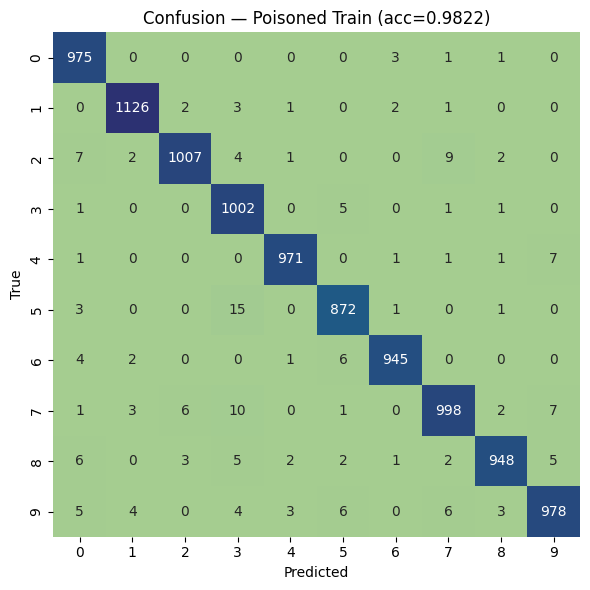

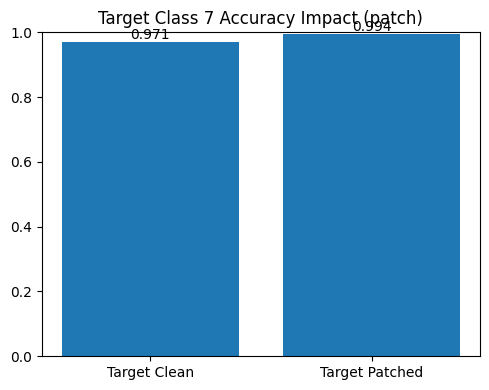

In [17]:
poison_imgs, poison_lbls = create_poisoned_dataset(x_train, y_train, target_class=TARGET_CLASS, num_poison=100, patch_size=PATCH_SIZE, patch_value=PATCH_VALUE, mode='feature')

# Replace a slice of the target-class images with patched versions
x_train_poisoned = x_train.copy()
y_train_poisoned = y_train.copy()
idx_target = np.where(y_train == TARGET_CLASS)[0][:len(poison_imgs)]
x_train_poisoned[idx_target] = poison_imgs

poison_model = build_cnn()
start = time.time()
poison_hist = poison_model.fit(x_train_poisoned, y_train_poisoned, epochs=POISON_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, verbose=2)
poison_time = time.time() - start

clean_loss, clean_acc = poison_model.evaluate(x_test, y_test, verbose=0)

# Evaluate impact on target class
idx_target_test = np.where(y_test == TARGET_CLASS)[0]
x_target_clean = x_test[idx_target_test]
x_target_patched = np.array([add_corner_patch(img, size=PATCH_SIZE, value=PATCH_VALUE) for img in x_target_clean])

pred_target_clean = np.argmax(poison_model.predict(x_target_clean, verbose=0), axis=1)
pred_target_patched = np.argmax(poison_model.predict(x_target_patched, verbose=0), axis=1)
acc_target_clean = float(np.mean(pred_target_clean == y_test[idx_target_test]))
acc_target_patched = float(np.mean(pred_target_patched == y_test[idx_target_test]))

cm_poison = confusion_matrix(y_test, np.argmax(poison_model.predict(x_test, verbose=0), axis=1))

poison_metrics = {
    'mode': 'feature',
    'target_class': TARGET_CLASS,
    'num_poisoned': int(len(poison_imgs)),
    'patch_size': PATCH_SIZE,
    'patch_value': PATCH_VALUE,
    'epochs': POISON_EPOCHS,
    'batch_size': BATCH_SIZE,
    'clean_loss': float(clean_loss),
    'train_time_seconds': float(poison_time),
    'clean_test_accuracy': float(clean_acc),
    'target_class_clean_accuracy': acc_target_clean,
    'target_class_patched_accuracy': acc_target_patched
}

save_json(BASE_DIR / 'poison_metrics.json', poison_metrics)
plot_confusion(cm_poison, f'Confusion — Poisoned Train (acc={clean_acc:.4f})', FIG_DIR / 'poison_confusion_matrix.png')

# Bar chart for trigger effect
fig = plt.figure(figsize=(5,4))
labels = ['Target Clean', 'Target Patched']
values = [acc_target_clean, acc_target_patched]
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels)
plt.ylim(0,1.0)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.title(f'Target Class {TARGET_CLASS} Accuracy Impact (patch)')
plt.tight_layout()
fig.savefig(FIG_DIR / 'poison_target_accuracy.png', bbox_inches='tight')
plt.show(); plt.close(fig)


## Aggregate Metrics Snapshot

In [18]:
metrics = aggregate_metrics({
    'baseline': BASE_DIR / 'baseline_metrics.json',
    'fgsm': BASE_DIR / 'fgsm_metrics.json',
    'advtrain': BASE_DIR / 'advtrain_metrics.json',
    'poison': BASE_DIR / 'poison_metrics.json'
})
# Save combined view
save_json(BASE_DIR / 'metrics_summary.json', metrics)

rows = [
    ['Baseline', metrics.get('baseline', {}).get('accuracy'), metrics.get('baseline', {}).get('loss'), metrics.get('baseline', {}).get('loss'), None, None],
    ['FGSM (adv acc)', metrics.get('fgsm', {}).get('baseline_adversarial_accuracy'), metrics.get('fgsm', {}).get('baseline_adversarial_loss'), metrics.get('fgsm', {}).get('baseline_clean_loss'), metrics.get('fgsm', {}).get('eps'), None],
    ['Adv-Trained Clean', metrics.get('advtrain', {}).get('advtrained_clean_accuracy'), metrics.get('advtrain', {}).get('advtrained_clean_loss'), None, metrics.get('advtrain', {}).get('eps'), None],
    ['Adv-Trained Adv', metrics.get('advtrain', {}).get('advtrained_adversarial_accuracy'), metrics.get('advtrain', {}).get('advtrained_adversarial_loss'), None, metrics.get('advtrain', {}).get('eps'), None],
    ['Poison Clean', metrics.get('poison', {}).get('clean_test_accuracy'), metrics.get('poison', {}).get('clean_loss'), None, None, metrics.get('poison', {}).get('target_class_patched_accuracy')]
]
summary_df = pd.DataFrame(rows, columns=['Scenario', 'Accuracy', 'Loss', 'Clean Loss', 'Eps', 'Target Patched Acc'])
display(summary_df)


Saved /Users/kartekeyaan/Chonky_folder/MNISTass/secure_ai_mnist/metrics_summary.json


,Scenario,Accuracy,Loss,Clean Loss,Eps,Target Patched Acc
0,Baseline,0.9837,0.314488,0.314488,NaN,NaN
1,FGSM (adv acc),0.6409,10.787150,0.314488,0.25,NaN
2,Adv-Trained Clean,0.9720,0.451605,NaN,0.25,NaN
3,Adv-Trained Adv,0.7474,5.013101,NaN,0.25,NaN
4,Poison Clean,0.9822,0.178276,NaN,NaN,0.994163


## STRIDE Notes
See full `THREAT_MODEL_STRIDE.md` for details. Key points: supply-chain and artifact integrity risks, adversarial/poison inputs cross trust boundaries; mitigations include hashing/signing models, bounded attack parameters, and logging attack configs.